In [82]:
##################----------------- Import Libraries -------------########################

from pyomo.environ import *
from pyomo.opt import SolverFactory
import math
import os
import numpy as np
import pandas as pd
import pandapower as pp
import pandapower.pf as pf
from pandapower import networks
import pandapower.plotting as plot
import pandapower.networks as pn
import matplotlib.pyplot as plt
import random
from scipy import stats
from scipy.stats import t
import sys
current_directory = os.getcwd()

In [83]:
# For auto reload libraries without the need to restart kernel
############# USE ONLY IN DEVELOPING MODE FOR EASIER MODIFICAITON IN LIBRARIES ##############
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
net = pn.simple_four_bus_system()
net.bus['max_vm_pu'] = 1.05
net.bus['min_vm_pu'] = 0.95

In [85]:
############## Initialize model ######################

sys.path.append('../ADN_OPF/src')

from Manager import *
manager = Manager(net=net)
manager.addTime(timeframe=48,time_interval=30) ## At objective, timeframe(in hours) , time-interval(in minutes)
manager.anc_Vars.System_Data_DER.loc[0,'Controllable']=True


In [86]:
#######################------------------- Easy method to get the admittance Matrix ----------------####################33
# Run a power flow calculation

pp.runpp(net)

# Access the Y-bus matrix from the network results
Ybus = net["_ppc"]["internal"]["Ybus"]
# print("Y-bus matrix:\n", Ybus.todense())

# Convert the sparse Y-bus matrix to a dense format and then to a DataFrame
Y_bus_df = pd.DataFrame(Ybus.todense())

# Add row and column labels if needed
Y_bus_df.index = net.bus.index
Y_bus_df.columns = net.bus.index
# print(Y_bus_df)
################### OR ######################

Ybus_custom = build_ybus(net)

### Generate load/DER time scale data
file_path2 = '../Data/profiles/pv_load_profiles/Profiles_for_testing.xlsx'
profiles = pd.read_excel(file_path2)
profiles = pd.concat([profiles]*2, ignore_index=True)

### Generate enviromen data
file_path2 = '../Data/profiles/Enviroment_profiles/dataset2.xlsx'
enviroment_data = pd.read_excel(file_path2, index_col='Time')
enviroment_data=enviroment_data.iloc[0:96,:]

print(Y_bus_df)
print(profiles.head())
print(enviroment_data.head())

yes
3.7499999999999997e-06
                    0                   1                   2  \
0  1.875150-5.962120j -1.357392-6.100772j  0.000000+0.000000j   
1  4.604728-4.225922j  2.365398-6.025498j -0.490248+0.063381j   
2  0.000000+0.000000j -0.490248+0.063381j  0.980497-0.126757j   
3  0.000000+0.000000j  0.000000+0.000000j -0.490248+0.063381j   

                    3  
0  0.000000+0.000000j  
1  0.000000+0.000000j  
2 -0.490248+0.063381j  
3  0.490248-0.063378j  
       Time  PV_Systems  PV_Rooftop  Load_Profile
0  00:00:00    0.000015    0.000015      0.122509
1  00:30:00    0.000015    0.000015      0.118885
2  01:00:00    0.000015    0.000015      0.116586
3  01:30:00    0.000016    0.000016      0.114244
4  02:00:00    0.000016    0.000016      0.111212
                      Tout  SolGlob
Time                               
2019-02-21T18:30:00Z   0.1        0
2019-02-21T19:00:00Z   0.2        0
2019-02-21T19:30:00Z   0.3        0
2019-02-21T20:00:00Z   0.3        0
2019-02-21T

In [87]:
# Custom Add EVs since in pandapower EVs are not available

# manager.anc_Vars.addEV(node=2,P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=57, EV_SoC_end=100, EV_SoC_min=35, EV_SoC_max=80, EV_cons=17,arrival=[31,31+48],departure=[13,13+48],distance=[1,1])
# manager.anc_Vars.addEV(node=3,P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=30, EV_SoC_end=100, EV_SoC_min=30, EV_SoC_max=80, EV_cons=17,arrival=[36,36+48],departure=[3,3+48],distance=[20,20])
# manager.anc_Vars.addFlexBuilding(node=2, P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf")
# manager.anc_Vars.addFlexBuilding(node=3, P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf")

# print(manager.anc_Vars.system_data_ev)
# print(manager.anc_Vars.system_data_ev_char)
# print(manager.anc_Vars.system_data_hp)

In [88]:
# This code initialize/create all the needed sets in pyomo model.
manager.initialize_sets()  # Initialize sets

print(manager.list_sets())
# manager.show_set("Sbuses")
# manager.show_set("SGenbuses")
# manager.show_set("SGrid")
# manager.show_set("SDER_contr")
# manager.show_set("SDER_uncontr")
# manager.show_set("SLoadbuses")
# manager.show_set("Slines")
# manager.show_set("STimes")
# manager.show_set("SEVbuses")
# manager.show_set("SDistance_ind")
# manager.show_set("SHPbuses")

['Sbuses', 'SGrid', 'SDER_contr', 'SDER_uncontr', 'SLoadbuses', 'Slines', 'STransformers', 'STimes', 'SEVbuses', 'SDistance_ind', 'SHPbuses', 'Sdownstream', 'Supstream', 'Sdownstream_transformer', 'Supstream_transformer', 'Sreverse_lines', 'Sreverse_transformers']


In [89]:
############################---------------------- Define Parameters ---------------------############################

# Why defined parameters? if we defined parameters instead of using for example panda dataframe then we can rerun the model without the need to 
# rebuild the constraints during the solving it automatically get the new parameters so the steps for a load modification example is the following
# 1) Define the load profile dataframe, 2) Run variables 3) Run parameters, 4)Build model, 5) Solve optimization, 6)Change load profile , 7) Run parameters ,8) Solve optimization
# MUTABLE=TRUE is the function parameter that allow this

manager.load_profile_param(profiles=profiles, load_p_name_prefix="Load_P", load_q_name_prefix="Load_Q") # This create Load_P and Load_Q profile which is equal to PandapowerPower*p.u. [from profiles files]
manager.line_param(Y_bus_df=Y_bus_df, resist_prefix="resistance_Parm", react_prefix="reactance_Parm", adm_real_prefix="admitt_mat_Parm_real", adm_img_prefix="admitt_mat_Parm_imag")
manager.transformer_param("transformer_resistance_Parm", "transformer_reactance_Parm") # This create resistance and reactance parameters for transformers
############ EV #################
manager.initialize_ev_params("ev_min_ch_param", "ev_max_ch_param", "EVinit_SOC", "EVend_SOC_param", "EV_SoC_min_param", "EV_SoC_max_param", "EV_capacity_param")
manager.initialize_ev_char_params("ev_arrival_time_param", "ev_departure_time_param", "ev_trip_distance_param", "EV_SoC_min_departure_param",  "EV_trip_energy_needs_param", "EV_available_param" )
manager.initialize_ev_min_soc_timeseries("EV_SoC_min_overtime_param")

############ DER #################
manager.der_profile_param(profiles, "unctrl_PV_gen_P", "unctrl_PV_gen_Q", "ctrl_PV_gen_P", "ctrl_PV_gen_Q")

############ HP #################
manager.initialize_hp_params("min_HP_power", "max_HP_power", "min_temp_preference_param", "max_temp_preference_param")
manager.enviroment_profile_param(enviroment_data, "Tout_param", "Qsolar_param")

print(manager.list_parameters())
manager.show_parameter("Load_P")

['Load_P', 'Load_Q', 'resistance_Parm', 'reactance_Parm', 'admitt_mat_Parm_real', 'admitt_mat_Parm_imag', 'transformer_resistance_Parm', 'transformer_reactance_Parm', 'ev_min_ch_param', 'ev_max_ch_param', 'EVinit_SOC', 'EVend_SOC_param', 'EV_SoC_min_param', 'EV_SoC_max_param', 'EV_capacity_param', 'ev_arrival_time_param', 'ev_departure_time_param', 'ev_trip_distance_param', 'EV_SoC_min_departure_param', 'EV_trip_energy_needs_param', 'EV_available_param', 'EV_SoC_min_overtime_param', 'unctrl_PV_gen_P', 'ctrl_PV_gen_P', 'unctrl_PV_gen_Q', 'ctrl_PV_gen_Q', 'min_HP_power', 'max_HP_power', 'min_temp_preference_param', 'max_temp_preference_param', 'Tout_param', 'Qsolar_param']
Variable Load_P:
  (2, 0): 0.0036752644392
  (2, 1): 0.00356655123
  (2, 2): 0.0034975863051
  (2, 3): 0.0034273171508999996
  (2, 4): 0.003336370929
  (2, 5): 0.0031993126830000005
  (2, 6): 0.0030531054132
  (2, 7): 0.0029361103880999996
  (2, 8): 0.0027957841179
  (2, 9): 0.0026178374244
  (2, 10): 0.002606093392199

In [90]:
############################---------------------- Define Variables ---------------------############################

# ###################### Normal Operation Scenario ########################
manager.initialize_voltage_variables(voltage_name_prefix="v", angle_name_prefix="pa")
manager.add_variable(variable_name_prefix="pgrid", variable_set=manager.model.SGrid)
manager.add_variable(variable_name_prefix="qgrid", variable_set=manager.model.SGrid)
manager.initialize_der_variables(power_control_name_prefix="pder_contr", power_curtail_prefix="pder_curtail_contr", reactive_prefix_name="qder_contr")
manager.initialize_line_variables(line_set=manager.model.Slines,system_data_df=manager.anc_Vars.System_Data_Lines, line_curr_name_prefix="Line_curr", line_act_curr_name_prefix="Line_act_curr",line_rea_curr_name_prefix="Line_rea_curr", line_losses_name_prefix = "Line_losses")
manager.initialize_line_variables(line_set=manager.model.STransformers,system_data_df=manager.anc_Vars.System_Data_Transformers, line_curr_name_prefix="Transformer_curr", line_act_curr_name_prefix="Transformer_act_curr",line_rea_curr_name_prefix="Transformer_rea_curr", line_losses_name_prefix = "Transformer_losses")

ref_bus=0 # THIS MUST BE ADDED AUTOMATICALLY 
for t in manager.model.STimes:
    manager.model.v[ref_bus, t].fix(1)
    manager.model.pa[ref_bus, t].fix(0)

###################### EV Variables ########################
manager.initialize_ev_variables(pch_name_prefix="pEVch",q_name_prefix="qEV", soc_name_prefix="EVsoc")

###################### HP and Building Variables ########################

manager.initialize_hp_variables(p_name_prefix="p_hp", q_name_prefix="q_hp")
manager.initialize_building_variables(model_type="3R2C", Qhp_name_prefix="Q_thermal", Tin_name_prefix="T_in", Te_name_prefix="T_e", min_temp_preference_param=manager.model.min_temp_preference_param , max_temp_preference_param=manager.model.max_temp_preference_param)

print(manager.list_variables())

['v', 'pa', 'pgrid', 'qgrid', 'pder_contr', 'pder_curtail_contr', 'qder_contr', 'Line_curr', 'Line_rea_curr', 'Line_act_curr', 'Line_losses', 'Transformer_curr', 'Transformer_rea_curr', 'Transformer_act_curr', 'Transformer_losses', 'pEVch', 'qEV', 'EVsoc', 'p_hp', 'q_hp', 'Q_thermal', 'T_in', 'T_e']


In [91]:
####################-------------------- Line Flow constraints -----------------------#######################

manager.add_real_current_flow_constraint(model_set=manager.model.Slines, active_curr_var=manager.model.Line_act_curr, current_flow_constr_name_prefix="real_line_flow", voltage_var=manager.model.v, phase_angle_var=manager.model.pa)
manager.add_reactive_current_flow_constraint(model_set=manager.model.Slines, reactive_curr_var=manager.model.Line_rea_curr, reactive_flow_constr_name_prefix="reactive_line_flow", voltage_var=manager.model.v, phase_angle_var=manager.model.pa)

manager.add_real_current_flow_constraint(model_set=manager.model.STransformers, active_curr_var=manager.model.Transformer_act_curr, current_flow_constr_name_prefix="real_transformer_flow", voltage_var=manager.model.v, phase_angle_var=manager.model.pa)
manager.add_reactive_current_flow_constraint(model_set=manager.model.STransformers, reactive_curr_var=manager.model.Transformer_rea_curr, reactive_flow_constr_name_prefix="reactive_transformer_flow", voltage_var=manager.model.v, phase_angle_var=manager.model.pa)

manager.add_twoport_amplitude_constraint(name_prefix="line_flow", x_var=manager.model.Line_rea_curr, y_var=manager.model.Line_act_curr, amp_var=manager.model.Line_curr,  model_set=manager.model.Slines)

## The transformer constraint is not added because something is wrong in the admittance matrix most probably in transformer terms
# manager.add_twoport_amplitude_constraint(name_prefix="Transformer_flow", x_var=manager.model.Transformer_rea_curr, y_var=manager.model.Transformer_act_curr, amp_var=manager.model.Transformer_curr,  model_set=manager.model.STransformers)

manager.add_line_flow_losses_constraint(manager.model.Line_curr, "line_losses")

###################-----------------Curtail DER Power Constrain ------------#######################

def Curtail_DER_Power_rule(model, i, time):
    return (model.pder_curtail_contr[i,time] ==  model.pder_curtail_contr[i,  time].ub - model.pder_contr[i,  time])
manager.model.Curtail_DER_cons = Constraint(manager.model.SDER_contr,manager.model.STimes, rule=Curtail_DER_Power_rule)  # Minimum, Maximum power for Gen

####################-------------------- EV Constrain -----------------------#######################

manager.add_ev_soc_constraint("EV_SOC_cons")
# Fix variables for non-charging times
manager.fix_ev_non_charging_times(model_ev_ch=manager.model.pEVch, model_ev_flex_up=None, model_ev_flex_down=None)

####################-------------------- HP Constrain -----------------------#######################
manager.add_building_thermodynamic_constraint(Tin = manager.model.T_in, Te=manager.model.T_e, Qhp=manager.model.Q_thermal, Tout=manager.model.Tout_param,  
                                              Qsol= manager.model.Qsolar_param, Q_dynamic_prefix_name="Q_hp_dynamic_constraint", Te_dynamic_prefix_name="T_e_dynamic_constraint")
manager.add_HP_operation_constraint(Tout_param=manager.model.Tout_param, Qhp=manager.model.Q_thermal, php=manager.model.p_hp,qhp=manager.model.q_hp, php_operation_prefix_name="active_power_hp_operation_constraint", qhp_operation_prefix_name="reactive_power_hp_operation_constraint")

In [92]:
manager.add_active_power_flow_constraint(manager.model.pder_contr, manager.model.pgrid, manager.model.pEVch, manager.model.v, manager.model.pa, "active_power_flow", manager.model.p_hp)
manager.add_reactive_power_flow_constraint(manager.model.qder_contr, manager.model.qgrid, manager.model.qEV, manager.model.v, manager.model.pa, "reactive_power_flow", manager.model.q_hp)


In [93]:
####################-------------------- Objective -----------------------#######################

def obj_rule(model):

    losses_term = sum(model.Line_losses[sfrom, sto, time]
                      for time in model.STimes 
                      for sfrom, sto in model.Slines)

    curtail_term = 300*sum(model.pder_curtail_contr[der, time]
                       for der in model.SDER_contr
                       for time in model.STimes)
    
    return losses_term + curtail_term

manager.model.obj = Objective(rule=obj_rule, sense=minimize)


In [94]:
# Define the solver without syntax issues and include line breaks
solver = SolverFactory('ipopt')

solver.options['max_iter'] = 5000  # Increase the maximum number of iterations
solver.options['tol'] = 1e-10       # Set a smaller tolerance for convergence
solver.options['print_level'] = 5  # Higher levels provide more detailed output (0-12)
solver.options['acceptable_tol'] = 1e-2            # early stopping
# solver.options['output_file'] = 'ipopt_log.txt'  # Save IPOPT log to a file

results = solver.solve(manager.model, tee=True)

# After solving, print the results
print("Status: ", results.solver.status)
print("Termination Condition: ", results.solver.termination_condition)

# Check if the solution is feasible
if results.solver.termination_condition == TerminationCondition.optimal:
    
    print("successful")
    # Extract solver timing (wallclock time)
    solver_time = results.solver.time  # Total solving time in seconds
    print(f"Solver Time: {solver_time} seconds")

else:
    print("Infeasible solution.")

Ipopt 3.14.17: max_iter=5000
tol=1e-10
print_level=5
acceptable_tol=0.01


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     7104
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2208

Total number of variables............................:     2016
                     variables with only lower bounds:      192
                variables with lower and upper bounds:     1056
                     variables with only upper bounds:        0
Total number of eq

In [95]:
print("Objective value:", value(manager.model.obj))

manager.results.wrapper_var_results()
print(manager.results.list())
print(manager.results.EVsoc.head())

Objective value: 0.6159477869201818
['EVsoc', 'Line_act_curr', 'Line_curr', 'Line_losses', 'Line_rea_curr', 'Q_thermal', 'T_e', 'T_in', 'Transformer_act_curr', 'Transformer_curr', 'Transformer_losses', 'Transformer_rea_curr', 'pEVch', 'p_hp', 'pa', 'pder_contr', 'pder_curtail_contr', 'pgrid', 'qEV', 'q_hp', 'qder_contr', 'qgrid', 'v']
Empty DataFrame
Columns: []
Index: []


/Users/savvaspanagi/Library/CloudStorage/OneDrive-CyprusUniversityofTechnology/Python-Matlab - Codes/ADN-Optimization-Tool/Tutorials/../ADN_OPF/src/plot/plot_fun.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left', fontsize=8, title_fontsize=8,ncol=2)
/Users/savvaspanagi/Library/CloudStorage/OneDrive-CyprusUniversityofTechnology/Python-Matlab - Codes/ADN-Optimization-Tool/Tutorials/../ADN_OPF/src/plot/plot_fun.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left', fontsize=8, title_fontsize=8,ncol=2)
/Users/savvaspanagi/Library/CloudStorage/OneDrive-CyprusUniversityofTechnology/Python-Matlab - Codes/ADN-Optimization-Tool/Tutorials/../ADN_OPF/src/plot/plot_fun.py:32: UserWarning: No a

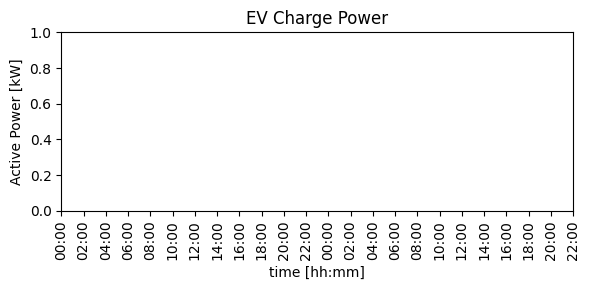

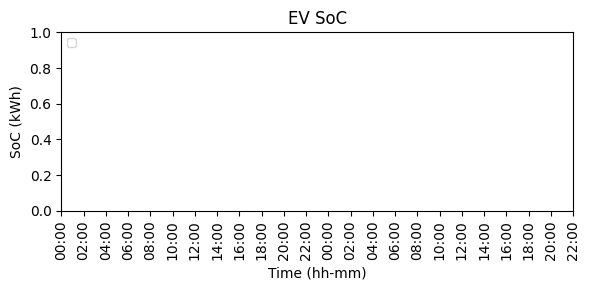

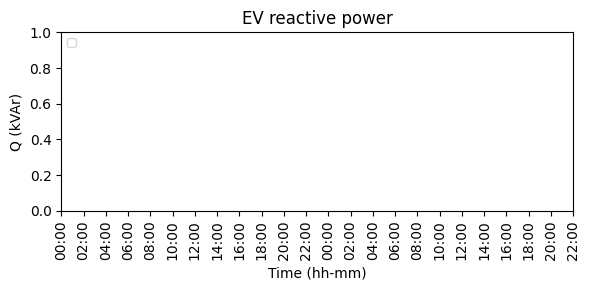

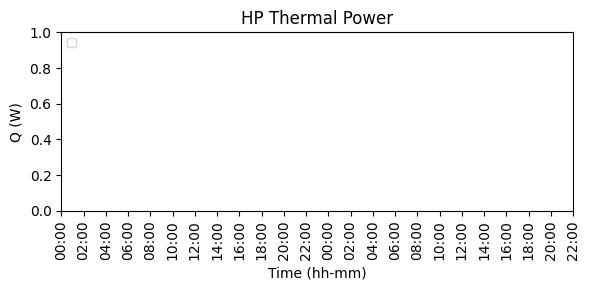

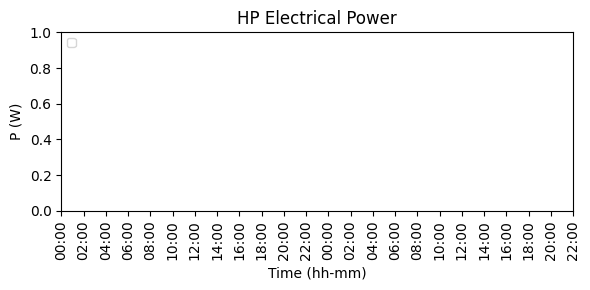

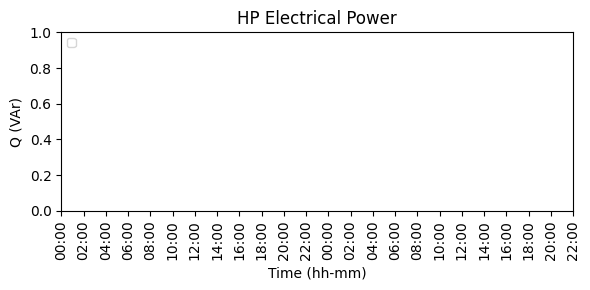

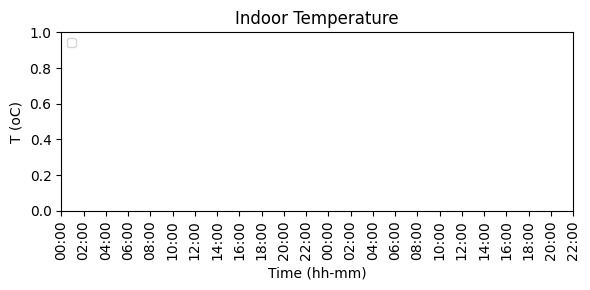

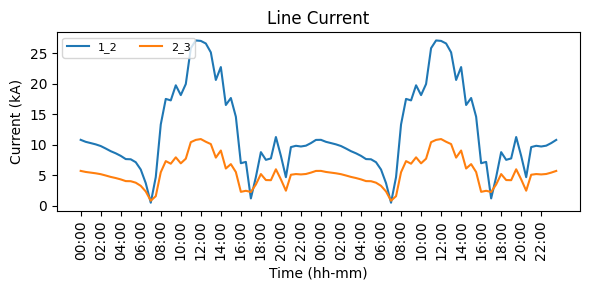

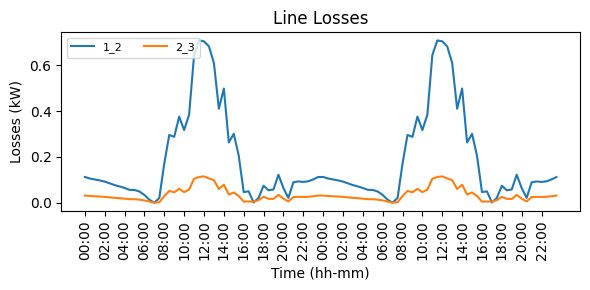

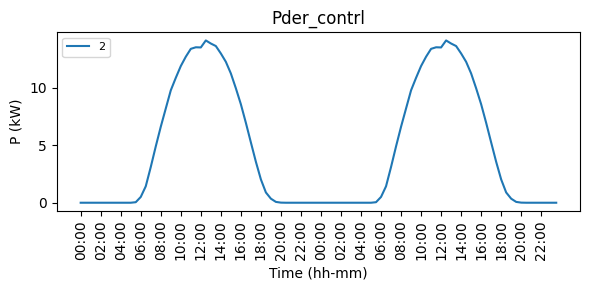

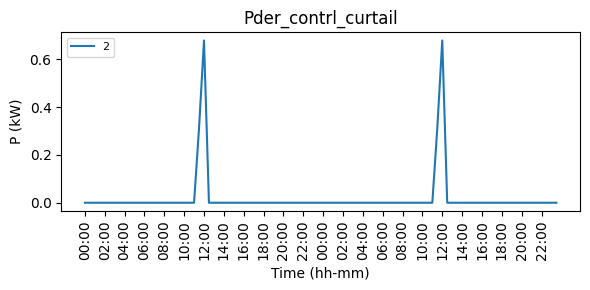

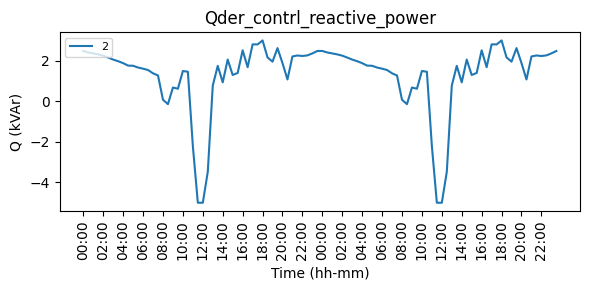

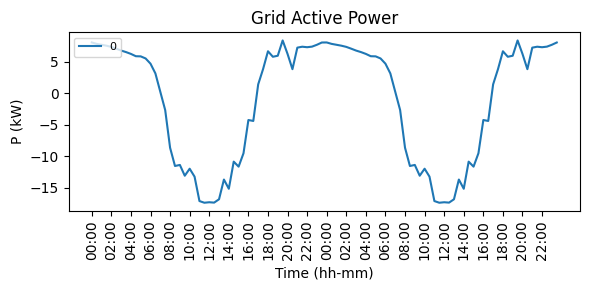

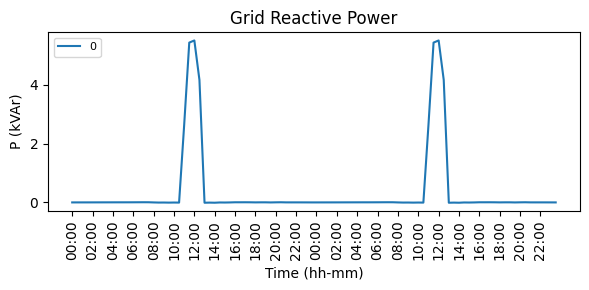

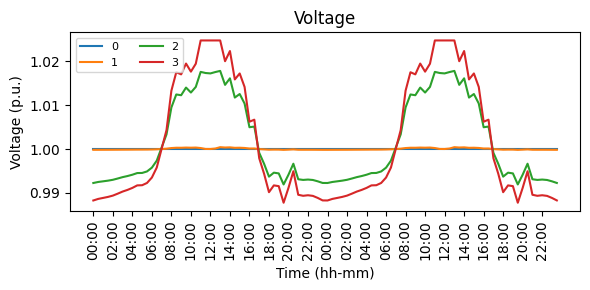

In [96]:
manager.plot_fun.result_df_plot(manager.results.pEVch*manager.anc_Vars.S_Base*1000,"EV Charge Power", "time [hh:mm]" ,"Active Power [kW]")
manager.plot_fun.result_df_plot(manager.results.EVsoc*manager.anc_Vars.S_Base*1000,"EV SoC", "Time (hh-mm)" ,"SoC (kWh)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.qEV*manager.anc_Vars.S_Base*1000,"EV reactive power", "Time (hh-mm)" ,"Q (kVAr)",label="Yes")

manager.plot_fun.result_df_plot(manager.results.Q_thermal,"HP Thermal Power", "Time (hh-mm)" ,"Q (W)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.p_hp*manager.anc_Vars.S_Base*1000*1000,"HP Electrical Power", "Time (hh-mm)" ,"P (W)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.q_hp*manager.anc_Vars.S_Base*1000*1000,"HP Electrical Power", "Time (hh-mm)" ,"Q (VAr)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.T_in,"Indoor Temperature", "Time (hh-mm)" ,"T (oC)",label="Yes")

manager.plot_fun.result_df_plot(manager.results.Line_curr*manager.anc_Vars.I_base*1000,"Line Current", "Time (hh-mm)" ,"Current (kA)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.Line_losses*manager.anc_Vars.S_Base*1000,"Line Losses", "Time (hh-mm)" ,"Losses (kW)",label="Yes")

manager.plot_fun.result_df_plot(manager.results.pder_contr*manager.anc_Vars.S_Base*1000,"Pder_contrl", "Time (hh-mm)" ,"P (kW)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.pder_curtail_contr*manager.anc_Vars.S_Base*1000,"Pder_contrl_curtail", "Time (hh-mm)" ,"P (kW)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.qder_contr*manager.anc_Vars.S_Base*1000,"Qder_contrl_reactive_power", "Time (hh-mm)" ,"Q (kVAr)",label="Yes")

manager.plot_fun.result_df_plot(manager.results.pgrid*manager.anc_Vars.S_Base*1000,"Grid Active Power", "Time (hh-mm)" ,"P (kW)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.qgrid*manager.anc_Vars.S_Base*1000,"Grid Reactive Power", "Time (hh-mm)" ,"P (kVAr)",label="Yes")


manager.plot_fun.result_df_plot(np.sqrt(manager.results.v),"Voltage", "Time (hh-mm)" ,"Voltage (p.u.)", label="Yes")
